# Spike Field and Reward Primitives

## Learning Objectives

By the end of this notebook, you will be able to:

- Convert spike trains to occupancy-normalized firing rate fields
- Use `spikes_to_field()` and `compute_place_field()` functions
- Understand min occupancy thresholds and their impact
- Generate reward fields for reinforcement learning
- Compare different reward decay profiles
- Apply reward shaping strategies to spatial navigation tasks

**Estimated time: 20-25 minutes**

## Setup

First, let's import the necessary libraries:

In [20]:
import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import Point

from neurospatial import (
    Environment,
    compute_place_field,
    goal_reward_field,
    region_reward_field,
    spikes_to_field,
)
from neurospatial.simulation import (
    PlaceCellModel,
    generate_poisson_spikes,
    simulate_trajectory_ou,
)

# Set random seed for reproducibility
np.random.seed(42)

# Configure matplotlib for clear, readable figures
plt.rcParams["figure.figsize"] = (14, 5)
plt.rcParams["font.size"] = 12
plt.rcParams["axes.labelsize"] = 13
plt.rcParams["axes.titlesize"] = 14
plt.rcParams["xtick.labelsize"] = 11
plt.rcParams["ytick.labelsize"] = 11
plt.rcParams["legend.fontsize"] = 11
plt.rcParams["figure.titlesize"] = 15

# Use colorblind-friendly colors (Wong palette)
WONG_COLORS = {
    "blue": "#0173B2",
    "orange": "#DE8F05",
    "green": "#029E73",
    "yellow": "#FBCA00",
    "purple": "#7C3C88",
    "cyan": "#56B4E9",
    "red": "#CC78BC",
}

---

## Part 1: Place Field Analysis - Recommended Workflow

This section demonstrates the **recommended approach** for computing place fields from spike data. We'll use `compute_place_field()`, which handles all the details automatically:

- Spike-to-bin mapping
- Occupancy normalization (spike count / time in bin)
- Boundary-aware smoothing (diffusion KDE)
- NaN handling for unvisited bins

**For most users, this is the only workflow you need.**

### Generate Synthetic Data

We'll use the `neurospatial.simulation` subpackage to generate realistic trajectories and spike trains. This subpackage provides:

- **`simulate_trajectory_ou()`**: Ornstein-Uhlenbeck random walk with biologically-realistic movement
- **`PlaceCellModel`**: Gaussian place field model with ground truth tracking
- **`generate_poisson_spikes()`**: Poisson spike generation with refractory period handling

These functions replace manual simulation code with a clean, tested API.

In [21]:
# 1. Create temporary environment for trajectory generation
# We'll use this to generate realistic movement within 80x80 cm arena
arena_size = 80.0  # cm
# Create a proper grid covering the full arena (not just corners!)
x = np.linspace(0, arena_size, 17)  # 17 points = 5 cm bins
y = np.linspace(0, arena_size, 17)
xx, yy = np.meshgrid(x, y)
arena_data = np.column_stack([xx.ravel(), yy.ravel()])  # 289 grid points
temp_env = Environment.from_samples(arena_data, bin_size=5.0)
temp_env.units = "cm"  # Required for trajectory simulation

# 2. Generate smooth random walk trajectory using Ornstein-Uhlenbeck process
duration = 800.0  # seconds (sufficient for uniform spatial coverage with rotational OU)
positions, times = simulate_trajectory_ou(
    temp_env,
    duration=duration,
    dt=0.01,  # 10ms timestep (required for numerical stability with rotational OU)
    speed_mean=7.5,  # cm/s (realistic rat movement)
    speed_std=0.4,  # cm/s (speed variability)
    coherence_time=0.7,  # seconds (smooth, persistent movement)
    boundary_mode="reflect",  # Reflect at boundaries for better 2D exploration
    seed=42,  # Seed produces uniform spatial coverage with rotational OU
)

# 3. Create place cell model with Gaussian tuning
preferred_location = np.array([60.0, 30.0])  # Right-bottom quadrant
tuning_width = 10.0  # cm
peak_rate = 15.0  # Hz

place_cell = PlaceCellModel(
    temp_env,
    center=preferred_location,
    width=tuning_width,
    max_rate=peak_rate,
    baseline_rate=0.001,  # Minimal baseline firing
    distance_metric="euclidean",
)

# 4. Generate spike train from place cell firing rates
firing_rates = place_cell.firing_rate(positions, times)
spike_times = generate_poisson_spikes(
    firing_rates,
    times,
    refractory_period=0.002,  # 2ms refractory period
    seed=42,
)

print(f"Generated trajectory: {len(times)} samples over {times[-1]:.1f} seconds")
print(f"Arena size: {arena_size:.0f}x{arena_size:.0f} cm")
print(
    f"Spatial coverage: X=[{positions[:, 0].min():.1f}, {positions[:, 0].max():.1f}], "
    f"Y=[{positions[:, 1].min():.1f}, {positions[:, 1].max():.1f}] cm"
)
print(
    f"Generated spikes: {len(spike_times)} spikes "
    f"(mean rate: {len(spike_times) / times[-1]:.2f} Hz)"
)
print(f"Place field center: {place_cell.ground_truth['center']}")

Generated trajectory: 80000 samples over 800.0 seconds
Arena size: 80x80 cm
Spatial coverage: X=[-2.5, 82.5], Y=[-2.5, 82.5] cm
Generated spikes: 1125 spikes (mean rate: 1.41 Hz)
Place field center: [60. 30.]


### Create Environment

Discretize the continuous space into spatial bins:

In [22]:
# Create environment from trajectory
env = Environment.from_samples(positions, bin_size=5.0)
env.units = "cm"

print(f"Environment: {env.n_bins} bins")
print(
    f"Spatial extent: X=[{env.dimension_ranges[0][0]:.1f}, {env.dimension_ranges[0][1]:.1f}] cm"
)
print(
    f"                Y=[{env.dimension_ranges[1][0]:.1f}, {env.dimension_ranges[1][1]:.1f}] cm"
)

Environment: 309 bins
Spatial extent: X=[-5.0, 85.0] cm
                Y=[-5.0, 85.0] cm


### Visualize Raw Data

Before computing place fields, let's see what we're working with - the animal's trajectory and where it spiked:

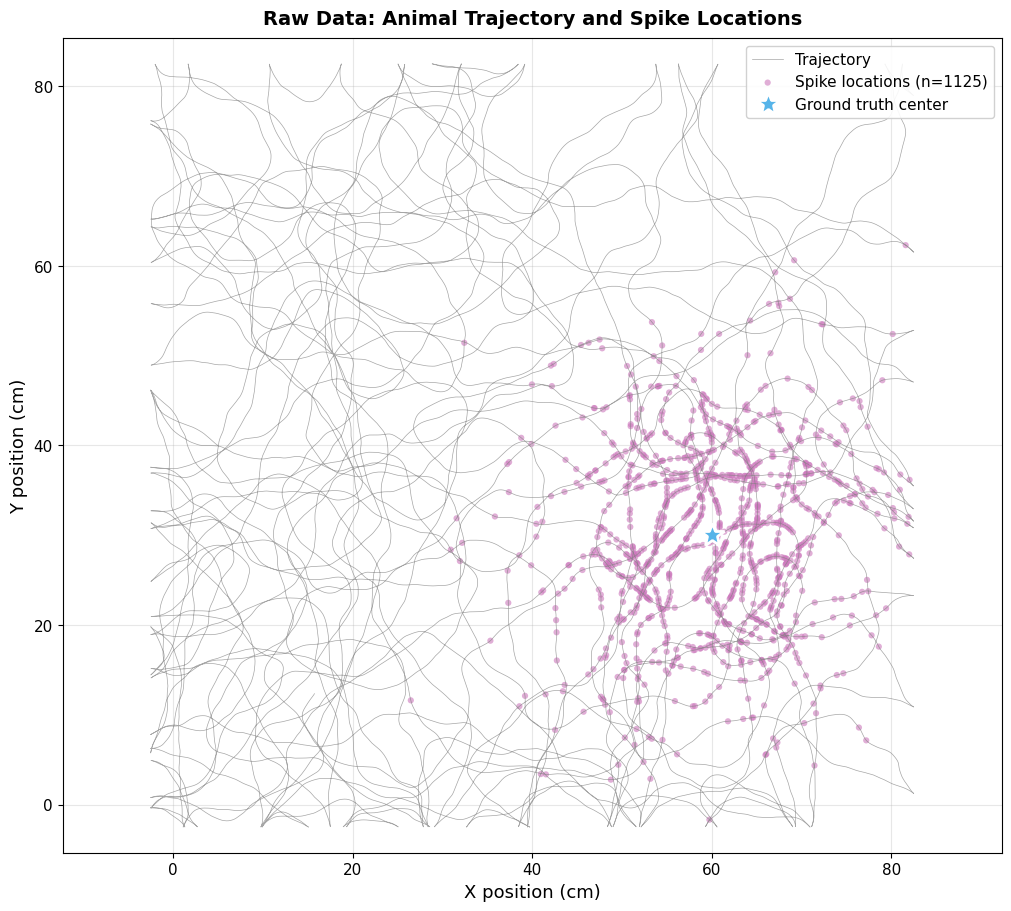

Total trajectory: 80000 samples over 800.0s
Spikes clustered around (60, 30) cm


In [23]:
# Visualize trajectory with spike locations
fig, ax = plt.subplots(figsize=(10, 9), constrained_layout=True)

# Plot full trajectory
ax.plot(
    positions[:, 0],
    positions[:, 1],
    "gray",
    alpha=0.7,
    linewidth=0.5,
    label="Trajectory",
)

# Mark spike positions
spike_positions = []
for spike_time in spike_times:
    # Find position at spike time
    idx = np.argmin(np.abs(times - spike_time))
    spike_positions.append(positions[idx])

spike_positions = np.array(spike_positions)

if len(spike_positions) > 0:
    ax.scatter(
        spike_positions[:, 0],
        spike_positions[:, 1],
        c=WONG_COLORS["red"],
        s=20,
        alpha=0.6,
        edgecolor="none",
        label=f"Spike locations (n={len(spike_positions)})",
    )

# Mark ground truth place field center
ax.plot(
    preferred_location[0],
    preferred_location[1],
    "*",
    color=WONG_COLORS["cyan"],
    markersize=18,
    markeredgecolor="white",
    markeredgewidth=2,
    label="Ground truth center",
)

ax.set_xlabel("X position (cm)")
ax.set_ylabel("Y position (cm)")
ax.set_title(
    "Raw Data: Animal Trajectory and Spike Locations",
    fontsize=14,
    fontweight="bold",
    pad=10,
)
ax.legend(loc="upper right", fontsize=11, framealpha=0.9)
ax.axis("equal")
ax.grid(True, alpha=0.3)

plt.show()

print(f"Total trajectory: {len(positions)} samples over {times[-1]:.1f}s")
print(
    f"Spikes clustered around ({preferred_location[0]:.0f}, {preferred_location[1]:.0f}) cm"
)

**Observation:** Spikes cluster around the ground truth place field center (cyan star). Now let's discretize this into spatial bins.

### Visualize Occupancy

How much time did the animal spend in each spatial bin?

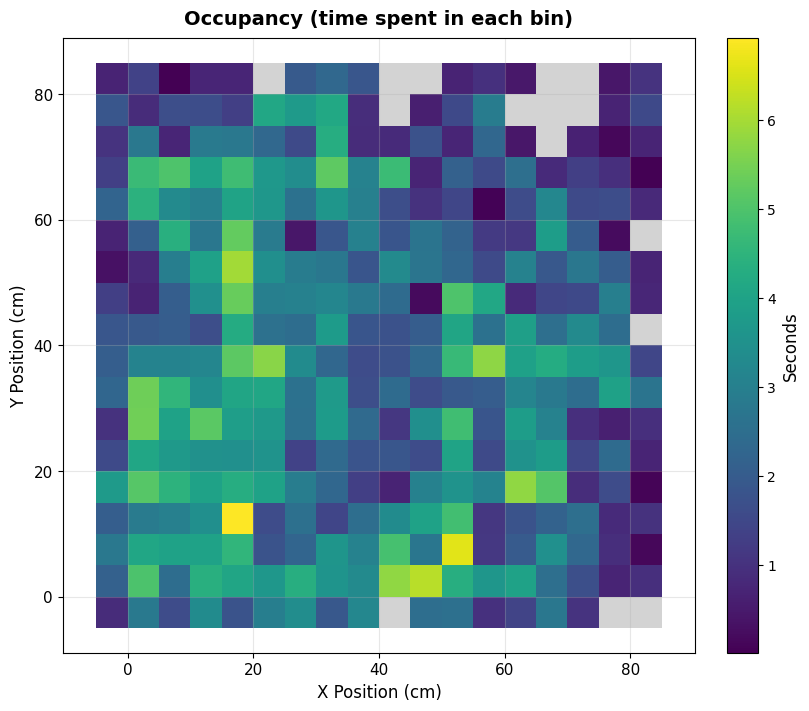

Occupancy range: 0.0 - 6.9 seconds
Bins with >0.5s: 296/309


In [24]:
# Compute occupancy
occupancy = env.occupancy(times, positions, return_seconds=True)

fig, ax = plt.subplots(figsize=(8, 7), constrained_layout=True)

env.plot_field(
    occupancy,
    ax=ax,
    cmap="viridis",
    colorbar_label="Seconds",
)
ax.set_title(
    "Occupancy (time spent in each bin)", fontsize=14, fontweight="bold", pad=10
)
ax.axis("equal")
ax.grid(True, alpha=0.3)

plt.show()

print(f"Occupancy range: {occupancy.min():.1f} - {occupancy.max():.1f} seconds")
print(f"Bins with >0.5s: {np.sum(occupancy > 0.5)}/{env.n_bins}")

**Why occupancy matters:** Without normalization, bins with more time would show more spikes simply from sampling, not neural preference.

### Compute Place Field (Recommended Approach)

**Use `compute_place_field()` for most applications** - it handles spike conversion, occupancy normalization, and smoothing in one call:

In [25]:
# One-liner: compute smoothed place field using boundary-aware diffusion KDE
place_field = compute_place_field(
    env,
    spike_times,
    times,
    positions,
    method="diffusion_kde",  # Boundary-aware smoothing (recommended)
    bandwidth=8.0,  # Smoothing bandwidth in cm
    min_occupancy_seconds=0.5,  # Exclude bins with <0.5s occupancy
)

print(f"Place field computed using diffusion KDE")
print(f"Peak firing rate: {np.nanmax(place_field):.2f} Hz")
print(f"Valid bins: {np.sum(~np.isnan(place_field))}/{env.n_bins}")

Place field computed using diffusion KDE
Peak firing rate: 7.06 Hz
Valid bins: 309/309


**Why `compute_place_field()` is recommended:**

- **One function call** - handles all steps automatically
- **Occupancy normalization** - divides spike counts by time in each bin
- **Boundary-aware smoothing** - diffusion KDE respects environment boundaries
- **Standard in neuroscience** - implements best practices from the literature

For most users, this is the **only function you need** for place field analysis.

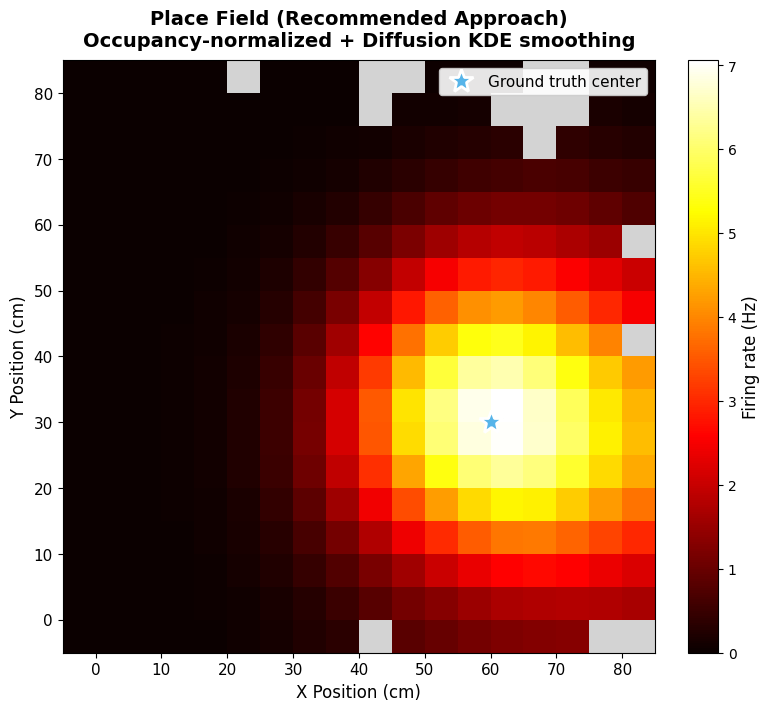


Place field successfully captures neural selectivity around (60, 30) cm


In [26]:
# Visualize the place field
fig, ax = plt.subplots(figsize=(8, 7), constrained_layout=True)

env.plot_field(
    place_field,
    ax=ax,
    cmap="hot",
    vmin=0,
    colorbar_label="Firing rate (Hz)",
)
ax.set_title(
    "Place Field (Recommended Approach)\nOccupancy-normalized + Diffusion KDE smoothing",
    fontsize=14,
    fontweight="bold",
    pad=10,
)
ax.plot(
    preferred_location[0],
    preferred_location[1],
    "*",
    color=WONG_COLORS["cyan"],
    markersize=18,
    markeredgecolor="white",
    markeredgewidth=2,
    label="Ground truth center",
)
ax.legend(loc="upper right", fontsize=11, framealpha=0.9)

plt.show()

print(
    f"\nPlace field successfully captures neural selectivity around ({preferred_location[0]:.0f}, {preferred_location[1]:.0f}) cm"
)

---

## Part 2: Understanding the Components (Advanced)

The sections below show the **low-level details** of how place fields are computed. Most users can skip this - `compute_place_field()` handles everything automatically.

### Manual Approach with `spikes_to_field()`

For fine-grained control, you can manually compute firing rates using `spikes_to_field()`:

In [27]:
# Manual approach: compute firing rate field without smoothing
firing_rate_raw = spikes_to_field(
    env,
    spike_times,
    times,
    positions,
    min_occupancy_seconds=0.0,  # Include all bins
)

firing_rate_filtered = spikes_to_field(
    env,
    spike_times,
    times,
    positions,
    min_occupancy_seconds=0.5,  # Standard threshold
)

# Compute occupancy for visualization
occupancy = env.occupancy(times, positions, return_seconds=True)

print("Manual firing rate computation:")
print(f"  Raw: {np.nanmin(firing_rate_raw):.2f} - {np.nanmax(firing_rate_raw):.2f} Hz")
print(
    f"  Filtered: {np.nanmin(firing_rate_filtered):.2f} - {np.nanmax(firing_rate_filtered):.2f} Hz"
)
print(f"  NaN bins: {np.sum(np.isnan(firing_rate_filtered))}/{env.n_bins}")

Manual firing rate computation:
  Raw: 0.00 - 17.33 Hz
  Filtered: 0.00 - 17.33 Hz
  NaN bins: 13/309


### Visualize: Occupancy vs Firing Rate

Let's compare occupancy, raw firing rate, and filtered firing rate:

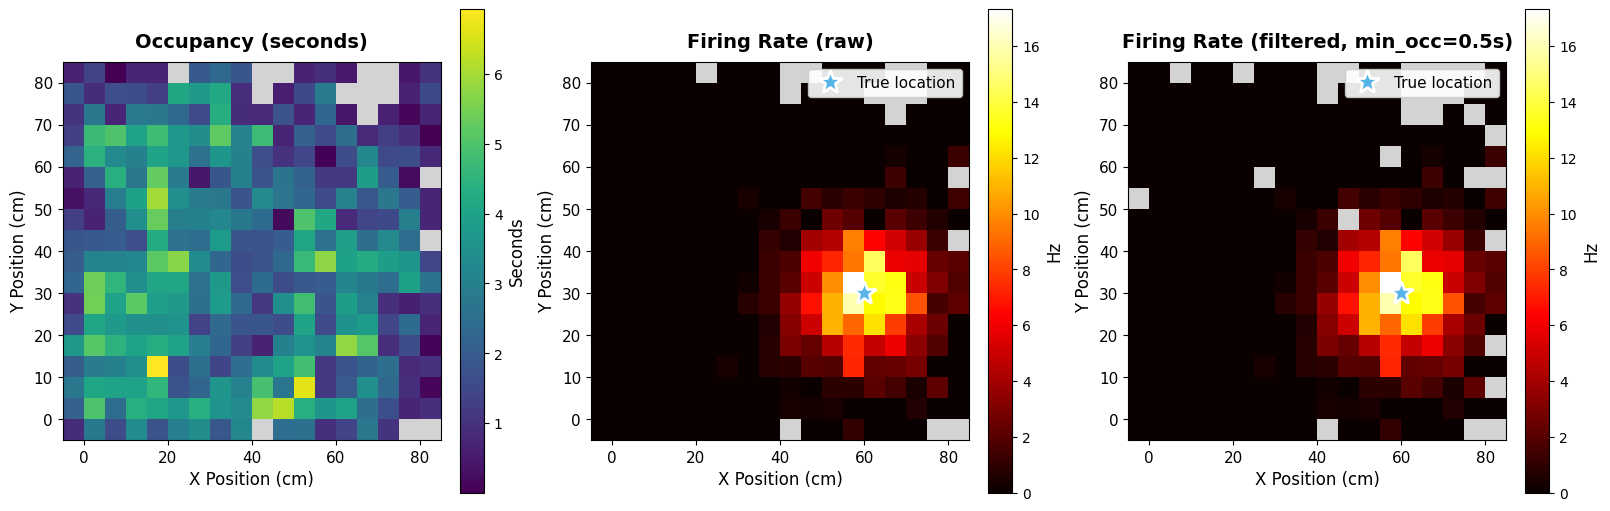

In [28]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5), constrained_layout=True)

# Plot occupancy
env.plot_field(
    occupancy,
    ax=axes[0],
    cmap="viridis",
    colorbar_label="Seconds",
)
axes[0].set_title("Occupancy (seconds)", fontsize=14, fontweight="bold", pad=10)

# Plot raw firing rate
env.plot_field(
    firing_rate_raw,
    ax=axes[1],
    cmap="hot",
    vmin=0,
    colorbar_label="Hz",
)
axes[1].set_title("Firing Rate (raw)", fontsize=14, fontweight="bold", pad=10)

# Plot filtered firing rate
env.plot_field(
    firing_rate_filtered,
    ax=axes[2],
    cmap="hot",
    vmin=0,
    colorbar_label="Hz",
)
axes[2].set_title(
    "Firing Rate (filtered, min_occ=0.5s)", fontsize=14, fontweight="bold", pad=10
)

# Mark preferred location
for ax in axes[1:]:
    ax.plot(
        preferred_location[0],
        preferred_location[1],
        "*",
        color=WONG_COLORS["cyan"],
        markersize=18,
        markeredgecolor="white",
        markeredgewidth=2,
        label="True location",
    )
    ax.legend(loc="upper right", fontsize=11, framealpha=0.9)

plt.show()

**Observations:**

- **Occupancy**: Shows spatial coverage from random walk exploration
- **Raw firing rate**: Includes all bins, even those with very brief visits (can be noisy)
- **Filtered firing rate**: Excludes unreliable bins (< 0.5 seconds), cleaner place field

The filtered version is **standard practice** in place field analysis.

**When to use manual approach:**

- Need to inspect occupancy separately
- Want to apply custom smoothing methods
- Debugging place field computation
- Research requiring non-standard processing

**For most applications, use `compute_place_field()` instead** (shown in Part 1).

---

## Part 3: Reward Fields for Reinforcement Learning

Reward shaping provides gradient information to help RL agents learn faster. However, it must be used carefully to avoid biasing policies toward suboptimal solutions.

### Region-Based Rewards

Let's create a goal region and explore different decay profiles:

In [29]:
# Define goal region at a bin center to ensure it's within the environment
# Pick a bin in the upper-right quadrant of the trajectory
goal_bin_idx = env.n_bins // 2 + env.n_bins // 4  # Approximately 3/4 through bins
goal_location = env.bin_centers[goal_bin_idx]
goal_circle = Point(goal_location).buffer(
    12.0
)  # 12 cm radius circle (covers ~4-5 bins)
env.regions.add("goal", polygon=goal_circle)

print(f"Goal region added at bin {goal_bin_idx}, location {goal_location}")
print(f"Goal region area: {env.regions.area('goal'):.1f} cm²")
print(f"Available regions: {list(env.regions.keys())}")

Goal region added at bin 231, location [62.49237179  7.50000354]
Goal region area: 451.7 cm²
Available regions: ['goal']


In [30]:
# Generate reward fields with different decay types
reward_constant = region_reward_field(env, "goal", reward_value=10.0, decay="constant")

reward_linear = region_reward_field(env, "goal", reward_value=10.0, decay="linear")

reward_gaussian = region_reward_field(
    env, "goal", reward_value=10.0, decay="gaussian", bandwidth=12.0
)

print("Region reward fields generated:")
print(
    f"  Constant: max={np.max(reward_constant):.2f}, non-zero bins={np.sum(reward_constant > 0)}"
)
print(
    f"  Linear: max={np.max(reward_linear):.2f}, non-zero bins={np.sum(reward_linear > 0)}"
)
print(
    f"  Gaussian: max={np.max(reward_gaussian):.2f}, non-zero bins={np.sum(reward_gaussian > 0)}"
)

Region reward fields generated:
  Constant: max=10.00, non-zero bins=21
  Linear: max=10.00, non-zero bins=308
  Gaussian: max=10.00, non-zero bins=309


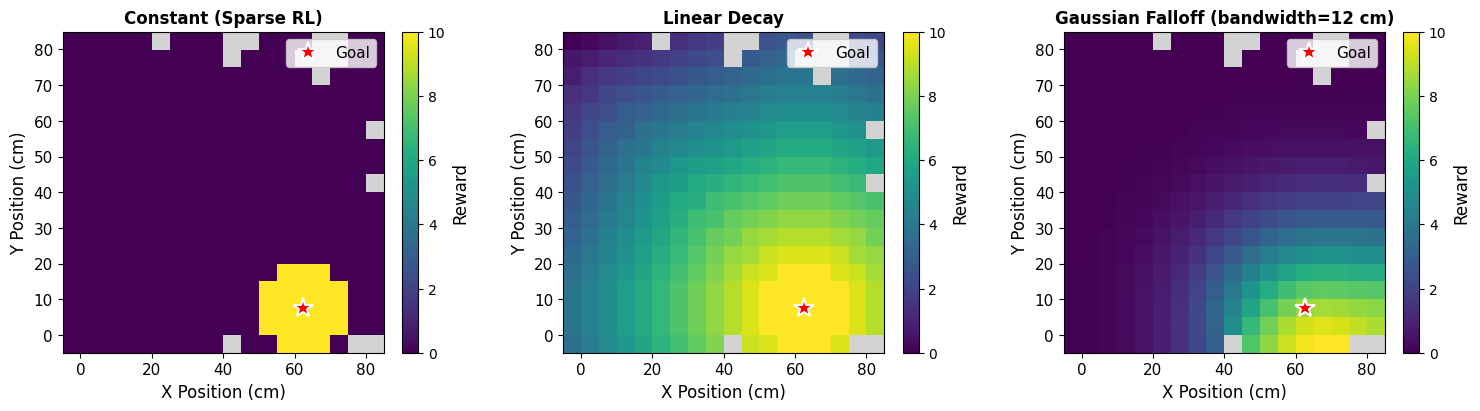

In [31]:
# Visualize region-based rewards
fig, axes = plt.subplots(1, 3, figsize=(15, 4), constrained_layout=True)

env.plot_field(
    reward_constant,
    ax=axes[0],
    cmap="viridis",
    vmin=0,
    vmax=10,
    colorbar_label="Reward",
)
axes[0].set_title("Constant (Sparse RL)", fontsize=12, fontweight="bold")
axes[0].plot(
    goal_location[0],
    goal_location[1],
    "r*",
    markersize=15,
    markeredgecolor="white",
    markeredgewidth=1.5,
    label="Goal",
)
axes[0].legend()

env.plot_field(
    reward_linear,
    ax=axes[1],
    cmap="viridis",
    vmin=0,
    vmax=10,
    colorbar_label="Reward",
)
axes[1].set_title("Linear Decay", fontsize=12, fontweight="bold")
axes[1].plot(
    goal_location[0],
    goal_location[1],
    "r*",
    markersize=15,
    markeredgecolor="white",
    markeredgewidth=1.5,
    label="Goal",
)
axes[1].legend()

env.plot_field(
    reward_gaussian,
    ax=axes[2],
    cmap="viridis",
    vmin=0,
    vmax=10,
    colorbar_label="Reward",
)
axes[2].set_title("Gaussian Falloff (bandwidth=12 cm)", fontsize=12, fontweight="bold")
axes[2].plot(
    goal_location[0],
    goal_location[1],
    "r*",
    markersize=15,
    markeredgecolor="white",
    markeredgewidth=1.5,
    label="Goal",
)
axes[2].legend()

plt.show()

**Key Differences:**

- **Constant**: Binary reward (10 inside goal, 0 elsewhere). No gradient guidance.
- **Linear**: Gradual decay from boundary. Provides gradient but normalizes by global max distance.
- **Gaussian**: Smooth falloff controlled by bandwidth. Best for gradient-based RL but most likely to bias policies.

**Important:** The Gaussian version rescales by the max **within the region** to preserve the intended reward magnitude (10.0).

### Goal-Based Distance Rewards

Now let's explore distance-based rewards from a goal bin:

In [32]:
# Select goal bin
goal_bin = env.bin_at(np.array([goal_location]))[0]
print(f"Goal bin index: {goal_bin}")

# Generate distance-based rewards
reward_exponential = goal_reward_field(env, goal_bin, decay="exponential", scale=15.0)

reward_linear_cutoff = goal_reward_field(
    env, goal_bin, decay="linear", scale=10.0, max_distance=50.0
)

reward_inverse = goal_reward_field(env, goal_bin, decay="inverse", scale=10.0)

print("\nGoal-based reward fields generated:")
print(
    f"  Exponential: max={np.max(reward_exponential):.2f}, min={np.min(reward_exponential):.4f}"
)
print(
    f"  Linear: max={np.max(reward_linear_cutoff):.2f}, min={np.min(reward_linear_cutoff):.4f}"
)
print(f"  Inverse: max={np.max(reward_inverse):.2f}, min={np.min(reward_inverse):.4f}")

Goal bin index: 231

Goal-based reward fields generated:
  Exponential: max=15.00, min=0.0168
  Linear: max=10.00, min=0.0000
  Inverse: max=10.00, min=0.0972


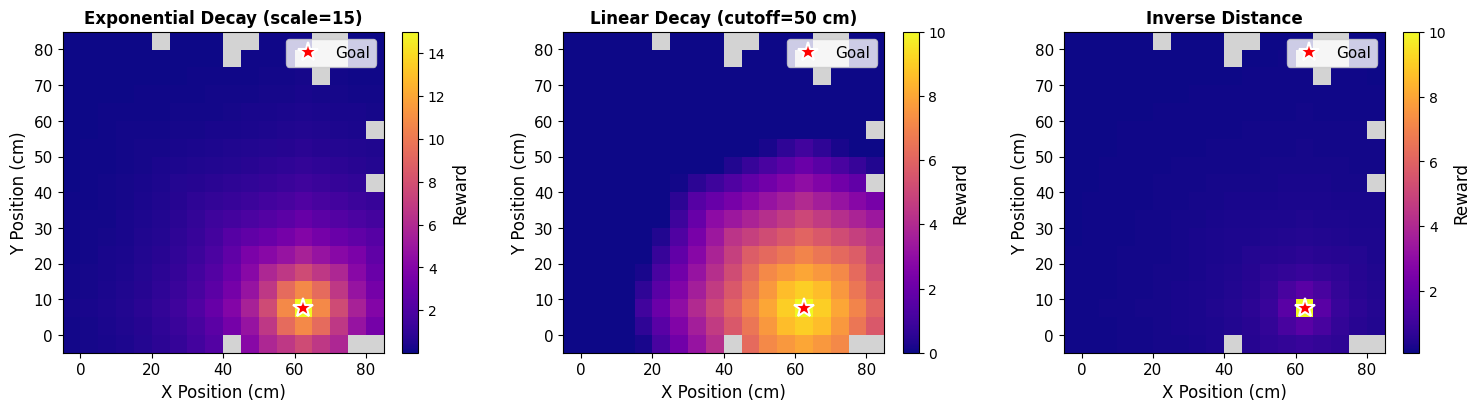

In [33]:
# Visualize goal-based rewards
fig, axes = plt.subplots(1, 3, figsize=(15, 4), constrained_layout=True)

env.plot_field(
    reward_exponential,
    ax=axes[0],
    cmap="plasma",
    colorbar_label="Reward",
)
axes[0].set_title("Exponential Decay (scale=15)", fontsize=12, fontweight="bold")
axes[0].plot(
    goal_location[0],
    goal_location[1],
    "r*",
    markersize=15,
    markeredgecolor="white",
    markeredgewidth=1.5,
    label="Goal",
)
axes[0].legend()

env.plot_field(
    reward_linear_cutoff,
    ax=axes[1],
    cmap="plasma",
    colorbar_label="Reward",
)
axes[1].set_title("Linear Decay (cutoff=50 cm)", fontsize=12, fontweight="bold")
axes[1].plot(
    goal_location[0],
    goal_location[1],
    "r*",
    markersize=15,
    markeredgecolor="white",
    markeredgewidth=1.5,
    label="Goal",
)
axes[1].legend()

env.plot_field(
    reward_inverse,
    ax=axes[2],
    cmap="plasma",
    colorbar_label="Reward",
)
axes[2].set_title("Inverse Distance", fontsize=12, fontweight="bold")
axes[2].plot(
    goal_location[0],
    goal_location[1],
    "r*",
    markersize=15,
    markeredgecolor="white",
    markeredgewidth=1.5,
    label="Goal",
)
axes[2].legend()

plt.show()

**Comparison:**

- **Exponential** (most common): Smooth decay, `reward = scale * exp(-d/scale)`. At distance=scale, reward ≈ 0.37*scale.
- **Linear**: Reaches exactly zero at cutoff distance. Constant gradient within range.
- **Inverse**: Never reaches zero, provides global gradients. Rarely used (can bias policies).

**Recommendation:** Use exponential decay as default. It's well-studied and most commonly used in RL literature.

### Multiple Goals

The goal-based rewards support multiple goal locations:

In [34]:
# Define two goals using bin centers to ensure they're within the environment
# Pick bins from opposite quadrants of the circular trajectory
goal_bin_1 = env.n_bins // 3  # Early bin (around 120 degrees)
goal_bin_2 = 2 * env.n_bins // 3  # Later bin (around 240 degrees)

goal_loc_1 = env.bin_centers[goal_bin_1]
goal_loc_2 = env.bin_centers[goal_bin_2]

# Create multi-goal reward field
multi_goal_reward = goal_reward_field(
    env, goal_bins=[goal_bin_1, goal_bin_2], decay="exponential", scale=15.0
)

print("Multi-goal reward field created")
print(f"Goal 1: bin {goal_bin_1} at {goal_loc_1}")
print(f"Goal 2: bin {goal_bin_2} at {goal_loc_2}")

Multi-goal reward field created
Goal 1: bin 103 at [22.49698812 62.4973766 ]
Goal 2: bin 206 at [52.49352587 62.4973766 ]


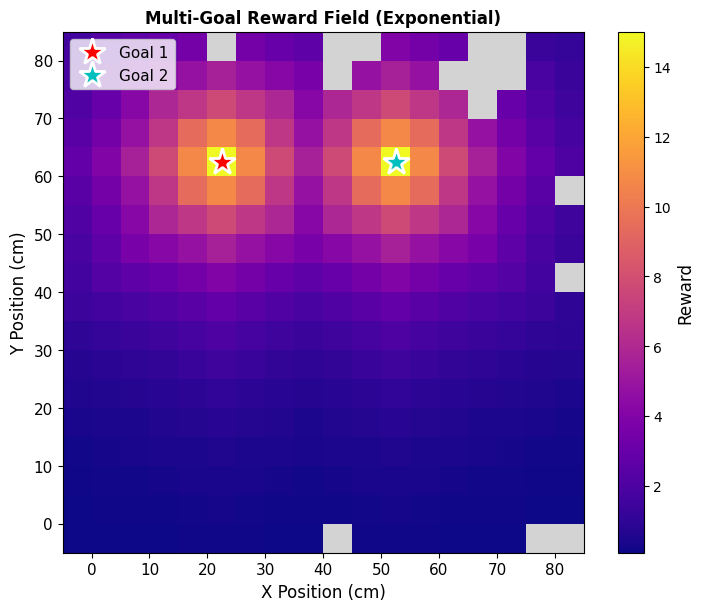

In [35]:
# Visualize multi-goal reward
fig, ax = plt.subplots(figsize=(8, 6), constrained_layout=True)

env.plot_field(
    multi_goal_reward,
    ax=ax,
    cmap="plasma",
    colorbar_label="Reward",
)
ax.set_title("Multi-Goal Reward Field (Exponential)", fontsize=12, fontweight="bold")
ax.plot(
    goal_loc_1[0],
    goal_loc_1[1],
    "r*",
    markersize=20,
    markeredgecolor="white",
    markeredgewidth=2,
    label="Goal 1",
)
ax.plot(
    goal_loc_2[0],
    goal_loc_2[1],
    "c*",
    markersize=20,
    markeredgecolor="white",
    markeredgewidth=2,
    label="Goal 2",
)
ax.legend(loc="upper left")

plt.show()

**Multi-goal behavior:** Each bin is influenced by its **nearest** goal, creating a Voronoi-like partition. Useful for multi-goal tasks or hierarchical RL.

---

## Part 4: Reward Shaping Best Practices

### Caution: When Shaping Can Hurt

From Ng et al. (1999):

> "Poorly designed reward shaping can cause agents to learn suboptimal policies that are difficult to correct."

**Key recommendations:**

1. **Start sparse**: Begin with constant (binary) rewards
2. **Add shaping cautiously**: Only if learning is too slow
3. **Validate policies**: Always compare shaped policy against sparse baseline
4. **Prefer exponential**: Well-studied, most commonly used in RL

### Combining Reward Sources

You can combine multiple reward fields for complex tasks:

In [36]:
# Primary goal (high reward)
primary_reward = region_reward_field(env, "goal", reward_value=100.0, decay="constant")

# Distance-based shaping (low weight)
shaping_reward = goal_reward_field(env, goal_bin, decay="exponential", scale=10.0)

# Combined reward (weight shaping less than primary)
combined_reward = primary_reward + 0.1 * shaping_reward

print(f"Primary reward max: {np.max(primary_reward):.1f}")
print(f"Shaping reward max: {np.max(shaping_reward):.1f}")
print(f"Combined reward max: {np.max(combined_reward):.1f}")

Primary reward max: 100.0
Shaping reward max: 10.0
Combined reward max: 101.0


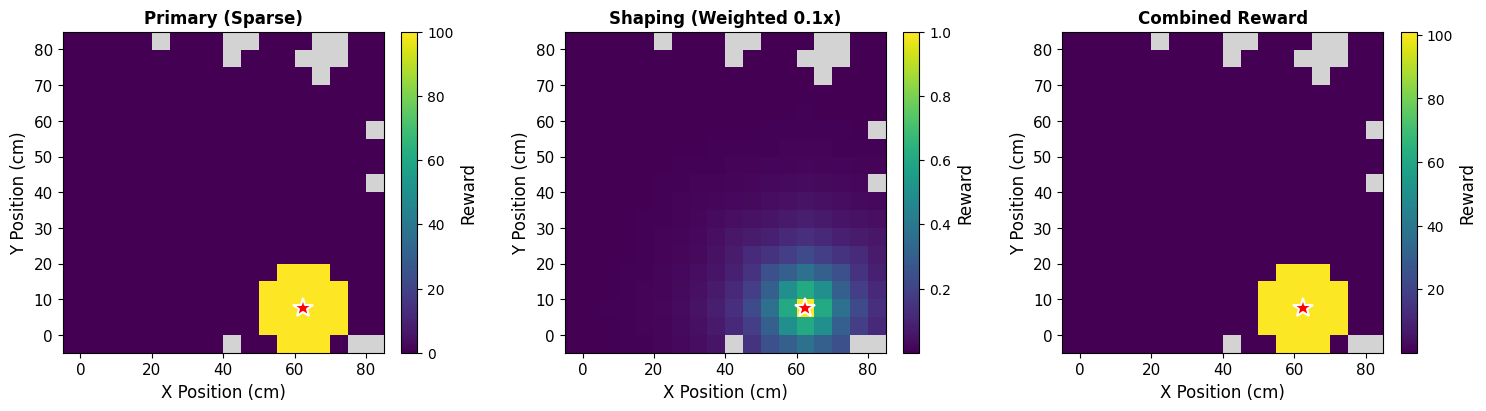

In [37]:
# Visualize combined rewards
fig, axes = plt.subplots(1, 3, figsize=(15, 4), constrained_layout=True)

env.plot_field(
    primary_reward,
    ax=axes[0],
    cmap="viridis",
    colorbar_label="Reward",
)
axes[0].set_title("Primary (Sparse)", fontsize=12, fontweight="bold")

env.plot_field(
    shaping_reward * 0.1,
    ax=axes[1],
    cmap="viridis",
    colorbar_label="Reward",
)
axes[1].set_title("Shaping (Weighted 0.1x)", fontsize=12, fontweight="bold")

env.plot_field(
    combined_reward,
    ax=axes[2],
    cmap="viridis",
    colorbar_label="Reward",
)
axes[2].set_title("Combined Reward", fontsize=12, fontweight="bold")

for ax in axes:
    ax.plot(
        goal_location[0],
        goal_location[1],
        "r*",
        markersize=15,
        markeredgecolor="white",
        markeredgewidth=1.5,
    )

plt.show()

**Strategy:** Keep the sparse reward dominant (100) and add a small shaping component (0.1 * 10 = 1). This provides gradient guidance while maintaining the correct optimal policy.

---

## Summary

In this notebook, you learned:

### Spike Field Conversion
- ✅ Convert spike trains to firing rate fields using `spikes_to_field()`
- ✅ Apply occupancy thresholds (`min_occupancy_seconds=0.5` is standard)
- ✅ Use `compute_place_field()` for one-liner workflows with smoothing
- ✅ Visualize occupancy, raw, and filtered firing rates

### Reward Field Generation
- ✅ Create region-based rewards (constant, linear, gaussian)
- ✅ Create goal-based distance rewards (exponential, linear, inverse)
- ✅ Handle multiple goals (Voronoi partitioning)
- ✅ Combine reward sources for complex tasks

### Best Practices
- ✅ Always validate shaped policies against sparse baselines
- ✅ Prefer exponential decay (well-studied, most common)
- ✅ Weight shaping components appropriately (keep sparse dominant)
- ✅ Be cautious: poorly designed shaping can bias policies!

### Next Steps
- Explore other layout engines (hexagonal, graph-based)
- Learn about differential operators for computing reward gradients
- Apply these techniques to real neural data
- Implement full RL algorithms using these reward primitives

---

## References

1. **O'Keefe, J., & Dostrovsky, J. (1971)**. "The hippocampus as a spatial map." *Brain Research*.

2. **Muller, R. U., Kubie, J. L., & Ranck, J. B. (1987)**. "Spatial firing patterns of hippocampal complex-spike cells in a fixed environment." *Journal of Neuroscience*.

3. **Ng, A. Y., Harada, D., & Russell, S. (1999)**. "Policy invariance under reward transformations: Theory and application to reward shaping." *ICML*.

4. **Sutton, R. S., & Barto, A. G. (2018)**. *Reinforcement Learning: An Introduction* (2nd ed.). MIT Press.